In [1]:
! curl "https://api.github.com/repos/huggingface/transformers/issues?page=1&per_page=1"

[
  {
    "url": "https://api.github.com/repos/huggingface/transformers/issues/29416",
    "repository_url": "https://api.github.com/repos/huggingface/transformers",
    "labels_url": "https://api.github.com/repos/huggingface/transformers/issues/29416/labels{/name}",
    "comments_url": "https://api.github.com/repos/huggingface/transformers/issues/29416/comments",
    "events_url": "https://api.github.com/repos/huggingface/transformers/issues/29416/events",
    "html_url": "https://github.com/huggingface/transformers/issues/29416",
    "id": 2165334917,
    "node_id": "I_kwDOCUB6oc6BEGOF",
    "number": 29416,
    "title": "The results of run_mae.py pre-training were abnormal",
    "user": {
      "login": "hhllxx1121",
      "id": 96508996,
      "node_id": "U_kgDOBcCcRA",
      "avatar_url": "https://avatars.githubusercontent.com/u/96508996?v=4",
      "gravatar_id": "",
      "url": "https://api.github.com/users/hhllxx1121",
      "html_url": "https://github.com/hhllxx1121",
      "

In [2]:
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000,
                 rate_limit=5_000):
    batch = []
    all_issues = []
    per_page = 100 # Number of issues to return per page
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"

    for page in tqdm(range(num_pages)):
        # Query with state=all to get both open and closed issues
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = [] # Flush batch for next time period
            print(f"Reached GitHub rate limit. Sleeping for one hour ...")
            time.sleep(60 * 60 + 1)

    all_issues.extend(batch)
    df = pd.DataFrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

In [3]:
import pandas as pd

df_issues = pd.read_json("/content/drive/MyDrive/issues.jsonl", lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


/usr/local/lib/python3.10/dist-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)
/usr/local/lib/python3.10/dist-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [4]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]

df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [5]:
df_issues["labels"] = (df_issues["labels"].apply(lambda x: [meta["name"] for meta in x]))
df_issues["labels"].head(10)

0             []
1             []
2    [DeepSpeed]
3             []
4             []
5             []
6             []
7             []
8             []
9             []
Name: labels, dtype: object

In [6]:
df_issues["labels"].apply(lambda x: len(x)).value_counts()

0    6440
1    3057
2     305
3     100
4      25
5       3
Name: labels, dtype: int64

In [7]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
df_counts.head()

Number of labels: 65


wontfix               2284
model card             649
Core: Tokenization     106
New model               98
Core: Modeling          64
Name: labels, dtype: int64

In [8]:
label_map = {
    "Core: Tokenization": "tokenization",
    "New model": "new model",
    "Core: Modeling": "model training",
    "Usage": "usage",
    "Core: Pipeline": "pipeline",
    "TensorFlow": "tensorflow or tf",
    "PyTorch": "pytorch",
    "Examples": "examples",
    "Documentation": "documentation"
    }

In [9]:
def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [10]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts

tokenization        106
new model            98
model training       64
usage                46
pipeline             42
tensorflow or tf     41
pytorch              37
documentation        28
examples             24
Name: labels, dtype: int64

In [11]:
df_issues["labels"].apply(lambda x: len(x)).value_counts()

0    9489
1     401
2      35
3       5
Name: labels, dtype: int64

In [12]:
df_issues["split"] = "unlabelled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labelled"
df_issues["split"].value_counts()

unlabelled    9489
labelled       441
Name: split, dtype: int64

In [13]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:200]}")

title: Add new CANINE model
body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only 
labels: ['new model']


In [14]:
df_issues["text"] = (df_issues.apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

<Axes: >

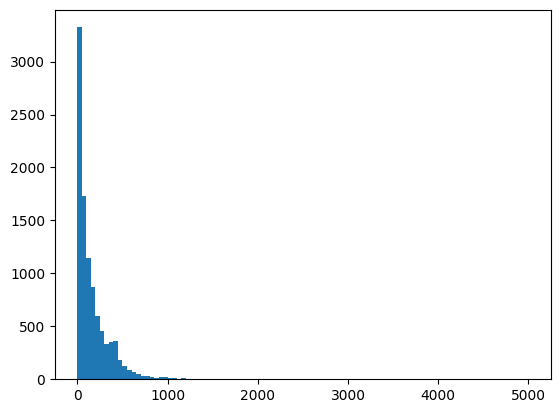

In [15]:
import numpy as np

df_issues['text'].str.split().apply(len).hist(bins=np.linspace(0, 5000, 101), grid=False)

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [17]:
!pip install -q scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00


In [18]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

In [19]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabelled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labelled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [20]:
df_train["labels"].value_counts()

[tokenization]                               53
[new model]                                  49
[model training]                             22
[pipeline]                                   18
[usage]                                      15
[documentation]                              14
[tensorflow or tf]                           13
[examples]                                   12
[pytorch]                                    11
[model training, tensorflow or tf]            3
[pytorch, usage]                              2
[model training, pytorch]                     2
[model training, pytorch, usage]              2
[model training, pipeline]                    1
[tensorflow or tf, usage]                     1
[model training, usage]                       1
[pipeline, tensorflow or tf]                  1
[pipeline, usage]                             1
[model training, tensorflow or tf, usage]     1
[pytorch, tensorflow or tf]                   1
Name: labels, dtype: int64

In [21]:
!pip install -q -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00


In [22]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train":
    Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid":
    Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
})
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 108
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 110
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9489
    })
})

In [23]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [24]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


In [25]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch['labels'])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Map:   0%|          | 0/9489 [00:00<?, ? examples/s]

In [26]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])

    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])

    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)

    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)

    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])


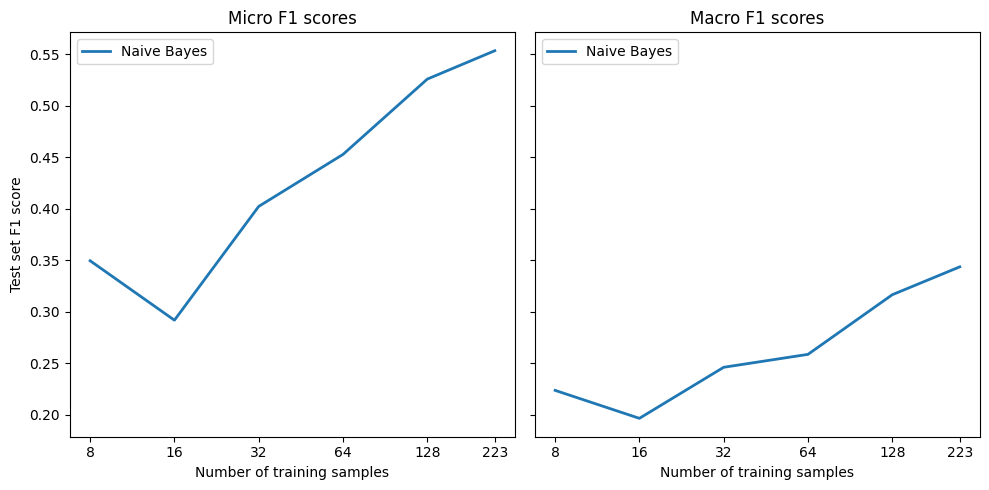

In [28]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")

    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.legend(loc="upper left")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()

plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

## Zero Shot Classification

In [30]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [31]:
sample = ds["train"][0]
print("label: ", sample["labels"])
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"])
print("\npredictions:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

label:  ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained input effective